## Get the data

In [1]:
import zipfile
# !wget /content/drive/MyDrive/Tensorflow_Certificate/Dataset_Kitchen.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Tensorflow_Certificate/Dataset_Kitchen.zip')
zip_ref.extractall()
zip_ref.close()

In [2]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirname,filenames in os.walk('Dataset_Kitchen'):
  print(f'There are {len(dirname)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 1 images in Dataset_Kitchen
There are 4 directories and 1 images in Dataset_Kitchen/testing
There are 0 directories and 266 images in Dataset_Kitchen/testing/Chair
There are 0 directories and 318 images in Dataset_Kitchen/testing/Kitchen
There are 0 directories and 392 images in Dataset_Kitchen/testing/Knife
There are 0 directories and 291 images in Dataset_Kitchen/testing/Saucepan
There are 4 directories and 1 images in Dataset_Kitchen/training
There are 0 directories and 1300 images in Dataset_Kitchen/training/Chair
There are 0 directories and 1300 images in Dataset_Kitchen/training/Kitchen
There are 0 directories and 1300 images in Dataset_Kitchen/training/Knife
There are 0 directories and 1300 images in Dataset_Kitchen/training/Saucepan


In [ ]:
# Let's visualize our iamges
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir,target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');

  print(f'Image shape: {img.shape}')

  return img

['chair_1402.jpg']
Image shape: (430, 430, 3)


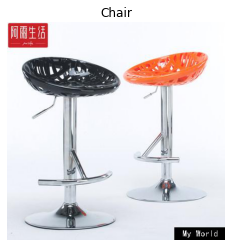

In [ ]:
img = view_random_image(target_dir = '/content/Dataset_Kitchen/testing/',
                  target_class='Chair')

In [ ]:
# View the Image shape
img.shape

(430, 430, 3)

## Loading Images from Directory (Image Generator)

In [ ]:
from matplotlib.rcsetup import validate_animation_writer_path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (Normalize)
train_datagen  = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)

# Setup paths to our data directories
train_dir = '/content/Dataset_Kitchen/training'
test_dir = '/content/Dataset_Kitchen/testing'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               seed=42)

Found 5200 images belonging to 4 classes.
Found 1267 images belonging to 4 classes.


## Model 1 : Baseline

In [5]:
# make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Activation
from tensorflow.keras import Sequential

In [6]:
# Added to avoid an Error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### Building and Fitting the Model

In [ ]:
# Create the model (Baseline)
model_1 = Sequential([
    Conv2D(filters=10, # Number of sliding windows going across an input
            kernel_size=3, # Size of the sliding window going across an input
            strides=1, # Size of the step the kernel takes across an input
            padding='valid', # if 'same', output shape is same as input shape ,if 'valid', ouput shape gets compressed
            activation='relu',
            input_shape=(224,224,3)), # Input layer

    Conv2D(10,3,activation='relu'),
    Conv2D(10,3,activation='relu'),
    Flatten(),
    Dense(4,activation='softmax')
])

# Compile the model
model_1.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)


# Fit the model
history_1 = model_1.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))


Epoch 1/5
163/163 [==============================] - 71s 424ms/step - loss: 1.2432 - accuracy: 0.5783 - val_loss: 0.7139 - val_accuracy: 0.7403
Epoch 2/5
163/163 [==============================] - 70s 427ms/step - loss: 0.3406 - accuracy: 0.8879 - val_loss: 0.6623 - val_accuracy: 0.7814
Epoch 3/5
163/163 [==============================] - 69s 420ms/step - loss: 0.0758 - accuracy: 0.9812 - val_loss: 0.8001 - val_accuracy: 0.7751
Epoch 4/5
163/163 [==============================] - 68s 416ms/step - loss: 0.0262 - accuracy: 0.9958 - val_loss: 0.8395 - val_accuracy: 0.7695
Epoch 5/5
163/163 [==============================] - 82s 505ms/step - loss: 0.0116 - accuracy: 0.9987 - val_loss: 1.0450 - val_accuracy: 0.7656


### Evaluate the model

In [ ]:
# Evaluate on the test data
model_1.evaluate(valid_data)

40/40 [==============================] - 14s 336ms/step - loss: 1.0450 - accuracy: 0.7656


[1.0450340509414673, 0.7655879855155945]

In [17]:
# Plot the validation and training curves seperately
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs,loss,label='Training Loss')
  plt.plot(epochs,val_loss,label='Val Loss')
  plt.title('Loss')
  plt.xlabel('epochs')
  plt.legend()

  # Plot Accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='Training Accuracy')
  plt.plot(epochs,val_accuracy,label='Val Accuracy')
  plt.title('Accuracy')
  plt.xlabel('epochs')
  plt.legend()

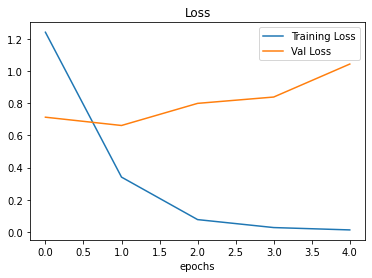

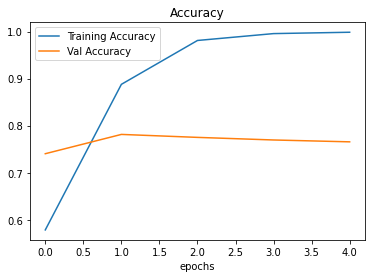

In [ ]:
# Check out the loss curves
plot_loss_curves(history_1)

## Model 2 : Data Augmentation

### Creating Data Generators

In [7]:
from matplotlib.rcsetup import validate_animation_writer_path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (Normalize)
# train_datagen  = ImageDataGenerator(rescale=1/255.0)
train_datagen_augmented = ImageDataGenerator(rescale=1/255., ## THIS IS THE CHANGE !!!! 
                                            rotation_range=0.2,
                                            shear_range=0.2,
                                            zoom_range=0.2,
                                            width_shift_range=0.2,
                                            height_shift_range=0.3,
                                            horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)

# Setup paths to our data directories
train_dir = '/content/Dataset_Kitchen/training'
test_dir = '/content/Dataset_Kitchen/testing'


# Import data from directories and turn it into batches
train_data_augmented = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224,224),
                                               class_mode='categorical',
                                               seed=42)

Found 5200 images belonging to 4 classes.
Found 1267 images belonging to 4 classes.


### Building and Fitting the model

In [14]:
# Cloning another model
# model_2 = tf.keras.models.clone_model(model_1)

# Create the model
model_2 = Sequential([
    Conv2D(10,3,input_shape=(224,224,3)),
    Activation(activation='relu'),

    Conv2D(10,3,input_shape=(224,224,3),activation='relu'),
    MaxPool2D(),

    Conv2D(10,3,input_shape=(224,224,3),activation='relu'),

    Conv2D(10,3,input_shape=(224,224,3),activation='relu'),
    MaxPool2D(),

    Flatten(),
    Dense(4,activation='softmax')

])


# Compile the model
model_2.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

# Fit the model
history_2 = model_2.fit(train_data_augmented,
            epochs=5,
            steps_per_epoch=len(train_data_augmented),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/5
 70/163 [===========>..................] - ETA: 1:04 - loss: 1.3133 - accuracy: 0.3951

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


163/163 [==============================] - 145s 816ms/step - loss: 1.1892 - accuracy: 0.4713 - val_loss: 0.9158 - val_accuracy: 0.6551
Epoch 2/5
163/163 [==============================] - 120s 732ms/step - loss: 0.9761 - accuracy: 0.6140 - val_loss: 0.8128 - val_accuracy: 0.7056
Epoch 3/5
163/163 [==============================] - 114s 700ms/step - loss: 0.8917 - accuracy: 0.6600 - val_loss: 0.7797 - val_accuracy: 0.7261
Epoch 4/5
163/163 [==============================] - 113s 695ms/step - loss: 0.8575 - accuracy: 0.6760 - val_loss: 0.7159 - val_accuracy: 0.7482
Epoch 5/5
163/163 [==============================] - 122s 750ms/step - loss: 0.8388 - accuracy: 0.6904 - val_loss: 0.6848 - val_accuracy: 0.7758


### Evaluate the model

In [15]:
model_2.evaluate(valid_data)

40/40 [==============================] - 13s 317ms/step - loss: 0.6848 - accuracy: 0.7758


[0.6848495006561279, 0.7758484482765198]

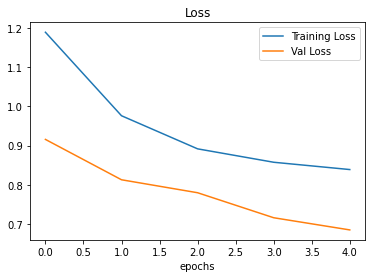

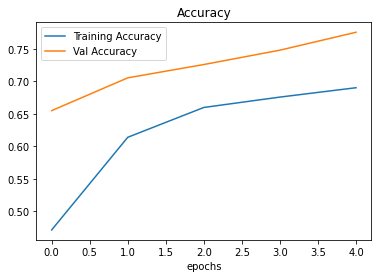

In [19]:
import matplotlib.pyplot as plt

plot_loss_curves(history_2)

## To do :   

1. Create Model Check points
2. Prefetch? (Need to make the model train faster)
3. Save the model and Load
4. Functional API
4. Use image_dataset_from_directory for data loading
5. Fine Tune
6. Load Checkpoint weights and predict

## Model 3 : Feature Extraction

Efficient Net Model

In [10]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers 

### Creating Feature Extraction Layer

In [20]:
# Creating Feature Extraction Layer
feature_extractor_layer = hub.KerasLayer('https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4',
                                           trainable=False,
                                           name='feature_extraction_layer',
                                           input_shape=(224,224,3)) # feaze the already learned patterns

### Building and Fitting the model

In [29]:
  # Create our own model
model_3 = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(4,activation='softmax',name='output_layer')
])

In [30]:
# Compile the model
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy']
)

In [31]:
# Fit the model
history_3 = model_3.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=valid_data,
                        validation_steps=len(valid_data),
                        )

Epoch 1/5
111/163 [===================>..........] - ETA: 33s - loss: 0.3309 - accuracy: 0.8883

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


163/163 [==============================] - 121s 730ms/step - loss: 0.2577 - accuracy: 0.9127 - val_loss: 0.0782 - val_accuracy: 0.9676
Epoch 2/5
163/163 [==============================] - 117s 719ms/step - loss: 0.0775 - accuracy: 0.9758 - val_loss: 0.0608 - val_accuracy: 0.9795
Epoch 3/5
163/163 [==============================] - 117s 718ms/step - loss: 0.0551 - accuracy: 0.9819 - val_loss: 0.0566 - val_accuracy: 0.9818
Epoch 4/5
163/163 [==============================] - 123s 756ms/step - loss: 0.0500 - accuracy: 0.9827 - val_loss: 0.0534 - val_accuracy: 0.9850
Epoch 5/5
163/163 [==============================] - 118s 723ms/step - loss: 0.0430 - accuracy: 0.9871 - val_loss: 0.0531 - val_accuracy: 0.9826


### Evaluate the model

In [32]:
model_3.evaluate(valid_data)

40/40 [==============================] - 27s 667ms/step - loss: 0.0531 - accuracy: 0.9826


[0.05308282747864723, 0.9826361536979675]

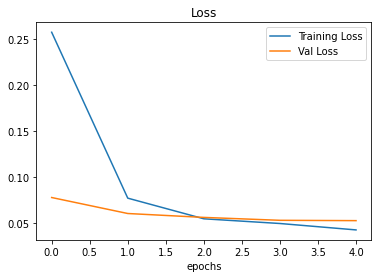

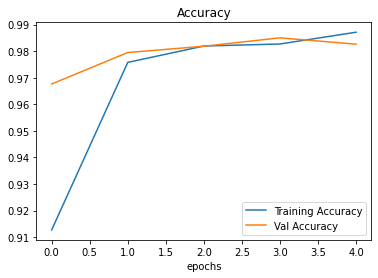

In [33]:
plot_loss_curves(history_3)